In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import numpy.linalg as la
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

# Hamiltonian Monte Carlo

### STA663 Final Project
#### Authors: Ilan Man and Sanjay Hariharan

1. Introduction
----

Hamiltonian Monte Carlo is a novel approach to Posterior estimation. It improves on the simple random-walk proposal of the Metropolis algorithm, by ensuring that these proposals are in the direction of steepest ascent (reference). In doing so, we avoid the slow exploration of the state space from these random proposals. HMC reduces the correlation between successive sampled states by using Hamiltonian evolution between states, a concept derived from quantum mechanics. The energy preserving aspect of Hamiltonian dynamics will be extremely useful in our derivation and implementation of this algorithm.

The remaining sections of this paper are structured as follows:
<ul>
<li>We introduce and review common MCMC methods. 
<ul>
<li>We discuss Gibbs Sampling, Metropolis-Hastings and Slice Sampling in the context of a bivariate Normal distribution.
<li>We show convergence under generic parameter settings
</ul>
<li>Then we introduce Hamiltonian dynamics and discuss its connection to MCMC and probability models. 
<li>We apply Hamiltonian Monte Carlo to the same bivariate Normal distribution and discuss its convergence under various parameter settings
<li>Finally we present empirical comparisons between Gibbs Sampling, Metropolis-Hastings and Hamiltonian Monte Carlo when we fit a linear regression model.
<ul>
<li>We also include examples of using Cython to speed up inefficiencies in the Metropolis-Hastings algorithm.
</ul>
</ul>

2. MCMC review
---
Markov Chain Monte Carlo (MCMC) methods are a class of algorithms for sampling from a proabability distribution based on sequential draws where each draw is dependent only on the previous value drawn, hence the draws form a Markov Chain. 

In Bayesian Inference, we obtain estimates for model parameters by sampling from the posterior distribution. MCMC methods are used extensively in calculating posterior distributions, which are often complex and intractable, and therefore must be approximated numerically. MCMC algorithms have certain attractive properties such as convergence to a limiting distribution, which we exploit in solving Bayesian Inference problems.

<h3>2.1 Motivation: Bivariate Normal</h3>

In the case of Heirarchical Bayesian Models, we often find the posterior distribution to be comprised of several parameters and is often intractable to solve. Even when tractable, we may find ourselves having to compute several complex integrals which require massive amounts of computing time. In real-world applications, practitioners commonly use MCMC methods to solve for these parameters. There are many flavors of MCMC and the modeler should identify which one to use in which case.

For the purposes of comparing the convergence of MCMC algorithms, we use a Bivariate Normal distribution. The parameters are as follows:

$$(\theta_1, \theta_2) \sim N(\mu, \Sigma)$$
$$\mu = \begin{pmatrix} x_1\\x_2\end{pmatrix}$$
$$\Sigma=\begin{pmatrix} 1 && \rho \\ \rho && 1 \end{pmatrix}$$

In our examples, we set $x_1 = 2, x_2 = 1$ and $\rho = 0.8$

We run each algorithm for $N = 1000$ iterations. 

Algorithm specific parameters are:

<ol>
<li>Gibbs
<ul>
<li>Assume uniform prior, Unif(0,1)
</ul>
<li>Metropolis-Hastings
<ul>
<li>Random Walk $N(0,1)$ proposal distribution
</ul>
<li>Slice Sampling
<ul>
<li>Use boundary step size, $w$, 0.2
</ul>
<li>Hamiltonian Monte Carlo
<ul>
<li>Leap steps: 30
<li>$\delta$ = 0.3
</ul>
</ol>


In [40]:
"""
INITIALIZE PARAMETERS FOR CONVERGENCE COMPARISONS FOR BIVARIATE DISTRIBUTION
"""

N = 1000
corr = 0.8

Covariance = np.array([[1,corr],
                       [corr,1]])

# gibbs params
mu = np.array([2,1])

# slice param
w = 0.2

# hmc params
delta = 0.3
leap = 30

<h3>2.2 Gibbs Sampling</h3>


Gibbs sampling is a specific variant of MCMC where each parameter of interest can be sampled directly, when conditioned across all the other parameters. This algorithm generates an instance from the distribution of each variable in turn, **conditional** on the current values of the other variables. This sequence of samples constitutes a Markov Chain whose stationary distribution is the sought-after joint distribution, $p(\theta_1, \theta_2,\dots,\theta_D)$

<h4>Gibbs Sampling Pseudo-Code</h4>

<ol>
<li>set $t = 0$<br>
<li>generate an initial state $\theta^{(0)} \sim \pi^{(0)}$<br>
<li>repeat until $t = M$<br>
<ol>
<li>set $t = t+1$<br>
<li>for each dimension $i = 1, ..., D$ <br>
<ul>
<li>draw $\theta_i^{(t)}$ from $p(\theta_i|\theta_1^{(t)},\theta_2^{(t)},\dots,\theta_{i-1}^{(t)},\theta_{i+1}^{(t)},\dots,\theta_D^{(t)})$<br>
</ol>
</ol>

For the case of the bivariate normal, the conditonal distributions are:

$$\theta_1|\theta_2, x \sim N(x_1 + \rho(\theta_2-x_2), 1-\rho^2)$$
$$\theta_2|\theta_1, x \sim N(x_2 + \rho(\theta_1-x_1), 1-\rho^2)$$

In [68]:
def gibbs_sampler(N, mu, corr):
    """
    Gibbs Sampling algorithm for a bivariate normal

    Parameters
    ----------
    N: number of iteration of the algorithm
    mu: mean of bivariate
    corr: correlation between x1 and x2
    
    Returns
    -------
    theta : ndarray of shape 2 x N. Transformed variable with Gibbs samples
    
    Raises
    ------
    Error if mu is not 2 dimensional
    Error if abs(corr) > 1
    
    """
    
    assert(mu.shape[0] == 2), "mean vector must be 2 dimensional for bivariate normal"
    assert(abs(corr) <= 1), "correlation must be between -1 and 1"
    
    theta = np.zeros(2*N).reshape(N,2)
    dimensions = range(mu.shape[0])

    for t in np.arange(N):
        for dim in dimensions:
            
            # conditional distribution for bivariate normal
            theta[t][dim] = stats.norm.rvs(loc = mu[dim] + corr*(theta[t][1-dim]-mu[1-dim]), 
                                           scale = np.sqrt(1 - corr**2))
    
    return theta

<h4>Shortcomings</h4>

The main shortcoming of Gibbs Sampling is the successive autocorrelation of the samples. Due to the fact that the sampling generates a Markov Chain, successive samples are correlated with each other. Thinning and Block Sampling may help reduce this correlation, but these heuristics sometimes don't work well or require lots of data. Another shortfall specific to Gibbs Sampling is that it requires identifying conditional distributions for each parameter. As with the posterior, some of these conditional distributions may have complex, intractable forms and will need other MCMC methods to compute them.

<h3>2.3 Metropolis-Hastings</h3>

The Metropolis algorithm is a generalization of Gibbs Sampling, useful when you cannot compute conditional sampling distributions in closed form. At each iteration of this algorithm, we propose a candidate for the next sample value of the parameter in question. The most common proposal method is a simple random walk, i.e. we sample from a Standard Normal Distribution. Then, with probability $\alpha$ the candidate is either accepted (updating our chain's next value with the candidate) or rejected (making the chain's next value equal to the current). $\alpha$ is the ratio of the posterior distribution with the proposed parameter over the posterior distribution with the previous parameter, truncated to 1.

<h4>Metropolis-Hastings Pseudo-Code</h4>

<ol>
<li>set $t = 0$<br>
<li>generate an initial state $\theta^{(0)} \sim \pi^{(0)}$<br>
<li>repeat until $t = N$<br>
<ol>
<li>set $t = t+1$<br>
<li>generate a proposal state $\theta^*$ from $q(\theta | \theta^{(t-1)})$<br>
<li>calculate the proposal correction factor $c = \frac{q(\theta^{(t-1)} | \theta^*) }{q(\theta^*|\theta^{(t-1)})}$<br>
<li>calculate the acceptance probability $\alpha = \text{min} \left (1,\frac{p(\theta^*)}{p(\theta^{(t-1)})} \times c\right )$ <br>
<li>draw a random number $u$ from Unif(0,1)<br>
<ol>
<li>if $u \leq \alpha$ accept the proposal state $\theta^*$ and set $\theta^{(t)}=\theta^*$<br>
<li>else set $\theta^{(t)} = \theta^{(t-1)}$
</ol>
</ol>
</ol>

In [69]:
def metropolis_hastings_MC(N, Cov):
    """
    Metropolis Hastings Monte Carlo algorithm for a bivariate normal

    Parameters
    ----------
    N: number of iteration of the algorithm
    Cov: covariance matrix
    
    Returns
    -------
    theta : ndarray of shape 2 x N. Transformed variable with Metropolis Hastings samples
    
    Raises
    ------
    Error if covariance is not positive semi definite
    
    """
    
    assert(np.all(la.eigvals(Cov)>=0)), "Covariance matrix must be Positive Semi-Definite"
    
    theta = np.zeros(2*N).reshape(N,2)
    
    def posterior(x, Cov):
        return stats.multivariate_normal.pdf(x, mean = np.array([0,0]), cov = Cov)
    
    for t in np.arange(1,N):

        # multivariate normal pproposal
        theta_star = np.random.multivariate_normal(theta[t-1,:], np.eye(2))

        # acceptance ratio
        alpha = min(1, posterior(theta_star, Cov)/posterior(theta[t-1,:], Cov))
        
        # accept/reject criterion
        theta[t,:] = theta_star if np.random.random() < alpha else theta[t-1,:]

    return theta

<h4>Shortcomings</h4>

The main shortcoming of the Metropolis Algorithm is that it explores the posterior space very slowly. This is due to the random walk behavior of the proposals. This makes the algorithm inefficient and requires a lot of computation to accurately estimate low-variance parameters.


<h3>2.4 Auxiliary Variables: Slice Sampling</h3>

Slice sampling is a simple MCMC algorithm that introudces the idea of auxiliary variables. The motivation for slice sampling is that if we can sample uniformly from the region under the graph of the target distribution, we will have random samples from the target distribution. 

<img src="prob_density.png"style="float: left; width: 300px;margin-left: 20%"><img src="prob_density_slices.png"style="width: 300px;margin-right: 20%">

<h4>Slice Sampling Pseudo-Code</h4>

Slice sampling, in its simplest form, samples uniformly from underneath the curve f(x) without the need to reject any points, as follows:

<ol>
<li>Choose a starting value $x_0$ for which f($x_0$)>0.
<li>Sample a y value uniformly between 0 and f($x_0$).
<li>Draw a horizontal line across the curve at this y position.
<li>Sample a point (x,y) from the line segments within the curve.
<li>Repeat from step 2 using the new x value.
</ol>

The motivation here is that one way to sample a point uniformly from within an arbitrary curve is first to draw thin uniform-height horizontal slices across the whole curve. Then, we can sample a point within the curve by randomly selecting a slice that falls at or below the curve at the x-position from the previous iteration, then randomly picking an x-position somewhere along the slice. By using the x-position from the previous iteration of the algorithm, in the long run we select slices with probabilities proportional to the lengths of their segments within the curve.

Generally, the trickiest part of this algorithm is finding the bounds of the horizontal slice, which involves inverting the function describing the distribution being sampled from. This is especially problematic for multi-modal distributions, where the slice may consist of multiple discontiguous parts. It is often possible to use a form of rejection sampling to overcome this, where we sample from a larger slice that is known to include the desired slice in question, and then discard points outside of the desired slice.

In [77]:
def slice_sampler(mu, Cov, w, N):
    """
    Slice Sampling algorithm for a bivariate normal. Using a Gibbs style conditional distribtion for generating 1-D slices

    Parameters
    ----------
    mu : mean of bivariate distribution to sample from
    Cov: covariance matrix
    w : size of step to increase horizontal interval for successive slices
    N : number of iterations
    
    Returns
    -------
    theta : ndarray of shape 2 x N with Slice samples
    
    Raises
    ------
    Error if covariance is not positive semi definite
    Error if mu is not 2 dimensional
    
    """
    
    assert(mu.shape[0] == 2), "mean vector must be 2 dimensional for bivariate normal"
    assert(np.all(la.eigvals(Cov)>=0)), "Covariance matrix must be Positive Semi-Definite"
    
    corr = Cov[0][1]
    
    x0 = stats.multivariate_normal.rvs(mean=mu, cov=Cov)
    
    theta = np.zeros(2*N).reshape(2,N).T
    dimensions = np.arange(theta.shape[1])

    for t in range(1,N):

        for dim in dimensions:

            # sample from conditional distribution f(y|x) ~ N(mu_, var_)
            # similar to Gibbs step
            
            mu_ = mu[dim] + corr*(theta[t][1-dim]-mu[1-dim])
            var_ = 1 - corr**2
            
            theta[t][dim] = stats.norm.rvs(loc = mu_, scale = np.sqrt(var_))

            # sample between 0 and f(x0) - this is the height of the horizontal slice
            # f(x) is the conditional bivariate, f(x|Y=y)
            y0 = np.random.uniform(0, stats.norm.pdf(x0[dim], loc = mu_, scale = var_))

            lb, rb = x0[dim], x0[dim]

            # create an interval where x0 lives. Take w-sized steps to increase the horizontal line
            while y0 < stats.norm.pdf(lb, loc = mu_, scale = np.sqrt(var_)) :
                lb -= w

            while y0 < stats.norm.pdf(rb, loc = mu_, scale = np.sqrt(var_)):
                rb += w

            # Once this interval is determined, sample uniformly from it for x1
            x0 = np.random.uniform(low = lb, high = rb, size = 2)

            # if generated point outside of the interval
            if y0 > stats.norm.pdf(x0[dim], loc = mu_, scale = np.sqrt(var_)) :
                if np.abs(x0[dim] - lb) < np.abs(x0[dim] - rb):
                    lb = x0[dim]
                else:
                    lb = y0

            else:
                theta[t][dim] = x0[dim]

    return theta

3. Hamiltonian Dynamics
----

Before we can develop Hamiltonian Monte Carlo, we must become familiar with the concept of Hamiltonian dynamics. Hamiltonian dymanics describes an object's motion in terms of its location $x$ and momentum $p$. Recall from high school physics that momentum $p$ is equal to an object's mass $m$ times its velocity $v$. For each location an object takes, there is an associated potential energy $U(x)$, and for each momentum there is an associated kineric energy $K(p)$. The total energy of the system is **constant** and is known as the Hamiltonian $H(x,p)$, defined as:
    
$$H(x,p) = U(x) + K(p)$$

This description is implemented quantitatively via a set of differential equations known as the Hamiltonian equations:

$$\frac{\partial x_i}{\partial t} = \frac{\partial H}{\partial p_i} = \frac{\partial K(\mathbf{p})}{\partial p_i}$$
$$\frac{\partial p_i}{\partial t} = -\frac{\partial H}{\partial x_i} = -\frac{\partial U(\mathbf{x})}{\partial x_i}$$

If we can solve for these partial derivatives, we can apply Hamiltonian Dynamics to more general cases. In order to simulate these dynamics numerically for computation, it is necessary to approximate the Hamiltonian equations by discretizing time. This is done by splitting up the interval $T$ into a series of smaller intervals of length $\delta$. The smaller the value of $\delta$ the closer the approximation is to the dynamics in continuous time, but the more computationally expensive is the procedure.


<h3>3.1 The Leap Frog Method</h3>

The Leap Frog Method is a popular method for numerically integrating differential equations, such as the Hamiltonian equations. The method updates the momentum and position variables sequentially, starting by simulating the momentum dynamics over a small interval of time $\frac{\delta}{2}$, then simulating the position dynamics over a slightly longer interval in time $\delta$, then completing the momentum simulation over another small interval of time $\frac{\delta}{2}$ so that x and p now exist at the same point in time. Specifically:<br>

1. Take a half step in time to update the momentum variable: <br>

  $p_i(t + \delta/2) = p_i(t) - (\delta /2)\frac{\partial U}{\partial x_i(t)}$ <br>

2. Take a full step in time to update the position variable <br>

  $x_i(t + \delta) = x_i(t) + \delta \frac{\partial K}{\partial p_i(t + \delta/2)}$ <br>

3. Take the remaining half step in time to finish updating the momentum variable <br>

  $p_i(t + \delta) = p_i(t + \delta/2) - (\delta/2) \frac{\partial U}{\partial x_i(t+\delta)}$ <br>

This method can be run for L steps to simulate dynamics over L x $\delta$ units of time. This particular method preserves the energy of the system and is time-reversible, and thus it is a popular choice for numerical approximations, especially in comparison with Euler's method:<br>

PUT PLOT OF EULER VS LEAPFROG FROM NEAL PAPER!!

<h3>3.2 MCMC from Hamiltonian dynamics</h3>

Using Hamiltonian dynamics to sample from a distribution requires translating the density function for this distribution to a potential energy function and introducing “momentum” variables to go with the original variables of interest (now seen as “position” variables). We can then simulate a Markov chain in which each iteration resamples the momentum and then does a Metropolis update with a proposal found using Hamiltonian dynamics.

How can we choose this Hamiltonian function? It turns out to be simple to relate $H(x, p)$ to $p(x)$ using a concept known as the **canonical distribution**. For any energy function $E(\theta)$, we define the corresponding canonical distribution as:

$p(\theta) = \frac{1}{Z}e^{-E(\mathbf\theta)}$

The variable Z is a normalizing constant called the partition function that scales the canonical distribution such that is sums to one, creating a valid probability distribution. 

Using the above equation for the total energy, we have:

$p(x,p) \propto e^{-H(x,p)} \\ = e^{-[U(x) - K(p)]} \\ = e^{-U(x)}e^{-K(p)} \\ \propto p(x)p(p)$

From above, see that the canonical distribution for x and p factorizes. We can now use Hamiltonian dynamics to sample from the joint canonical distribution over p and x and simply ignore the momentum contributions. Note that this is an example of introducing *auxiliary variables* to facilitate the Markov chain path.


<h3>3.3 Probability and the Hamiltonian</h3>

In HMC, we use Hamiltonian dynamics as a proposal function in order to explore the canonical (posterior) density $p(x)$ defined by $U(x)$ more efficiently. Starting at an initial state $[x_0, p_0]$, we simulate Hamiltonian dynamics for a short time using the Leap Frog method. We then use the position and momentum ariables at the end of the simulation as our porposed states variables $x^*$ and $p^*$. This proposed state is accepted with an update rule similar to Metropolis before:

$p(x^*, p^*) \propto e^{-[U(x^*) + K(p^*)]} \\ p(x_0, p_0) \propto e^{-[U(x^{(t-1)}), K(p^{(t-1)})]}$

Accept with probability:

min(1, $\frac{p(x^*, p^*)}{p(x^0, p^0)}$)

Similar to the Metropolis algorithm, if the state is rejected, the next state of the Markov Chain is set at the state (t-1). Note that Hamiltonian Dynamics will follow contours of constant energy in phase space. Therefore, in order to explore all of the posterior distribution, we draw a random momentum from the corresponding canonical distribution $p(\mathbf{p})$ before running the dynamics prior to each sampling iteration t.


<h3>3.4 Hamiltonian Monte Carlo Algorithm</h3>

<ol>
<li>set t = 0
<li>generate an initial position state $x^{(0)} \sim \pi^{(0)}$
<li>repeat until t = M
<ol>
<li>set t = t+1
<li>sample a new initial momentum variable from the momentum canonical distribution $p_0 \sim p(p)$
<li>set $x_0 = x^{(t-1)}$
<li>run Leap Frog algorithm starting at $[x_0, p_0]$ for L steps and stepsize $\delta$ to obtain proposed states $x^*$ and $p^*$
<li>calculate the Metropolis acceptance probability:
<li>- $\alpha = \text{min}(1,\exp(-U(x^*) + U(x_0) - K(p^*) + K(p_0)))$
<li>draw a random number u from $\text{Unif}$(0,1)<br>
- if $u \leq \alpha$ accept the proposed state position $x^*$ and set the next state in the Markov chain $x^{(t)}=x^*$<br>
- else set $x^{(t)} = x^{(t-1)}$
</ol>
</ol>

In [71]:
def hamiltonian_monte_carlo(N, leap, delta, Cov):
    """
    
    Hamiltonian Monte Carlo algorithm for a bivariate normal

    Parameters
    ----------
    N: number of iteration of the algorithm
    Cov: covariance matrix
    leap: number of steps of leap frog
    delta: step size for discrete approximation
    
    Returns
    -------
    theta : ndarray of shape 2 x N. Transformed variable with Hamiltonian samples

    Raises
    ------
    Error if leap or delta are negative
    Error if covariance is not positive semi definite
    
    """
    
    assert(leap > 0), "leap must be positive"
    assert(delta > 0), "delta must be positive"
    assert(np.all(la.eigvals(Cov)>=0)), "Covariance matrix must be Positive Semi-Definite"
    
    """ Hamiltonian helper functions """
    
    def potential_energy(x, Cov):
        return x.dot(la.inv(Cov.T)).dot(x.T)

    def grad_potential_energy(x, Cov):
        return x.dot(la.inv(Cov))

    def kinetic_energy(p):
        return np.sum(p.T.dot(p)/2)
    
    theta = np.zeros(2*N).reshape(N,2)
    
    for t in range(1,N):

        #   SAMPLE RANDOM MOMENTUM
        p0 = np.random.randn(2)

        #   SIMULATE HAMILTONIAN DYNAMICS
        #   FIRST 1/2 STEP OF MOMENTUM
        p_star = p0 - 1/2*delta*grad_potential_energy(theta[t-1,:], Cov)

        #   FIRST FULL STEP FOR POSITION/SAMPLE
        theta_star = theta[t-1,:] + delta*p_star

        #   FULL STEPS
        for i in range(leap):
            # MOMENTUM
            p_star = p_star - delta*grad_potential_energy(theta_star, Cov)
            # POSITION/SAMPLE
            theta_star = theta_star + delta*p_star

        p_star = p_star - 1/2*delta*grad_potential_energy(theta_star, Cov)

        U0 = potential_energy(theta[t-1,:], Cov)
        U_star = potential_energy(theta_star, Cov)

        K0 = kinetic_energy(p0)
        K_star = kinetic_energy(p_star)

        # acceptance ratio
        alpha = min(1, np.exp((U0 + K0) - (U_star + K_star)))

        # accept/reject criterion        
        theta[t,:] = theta_star if np.random.random() < alpha else theta[t-1,:]
        
    return theta


4. Empirical Analysis: Bivariate Normal
---

In [72]:
%timeit x_GIBBS = gibbs_sampler(N, mu, corr)

10 loops, best of 3: 41.2 ms per loop


In [73]:
%timeit x_MHMC = metropolis_hastings_MC(N, Covariance)

1 loop, best of 3: 290 ms per loop


In [74]:
%timeit x_SLICE = slice_sampler(mu, Covariance, 0.2, N)

1 loop, best of 3: 9.77 s per loop


In [75]:
%timeit x_HMC = hamiltonian_monte_carlo(N, leap, delta, Covariance)

1 loop, best of 3: 513 ms per loop


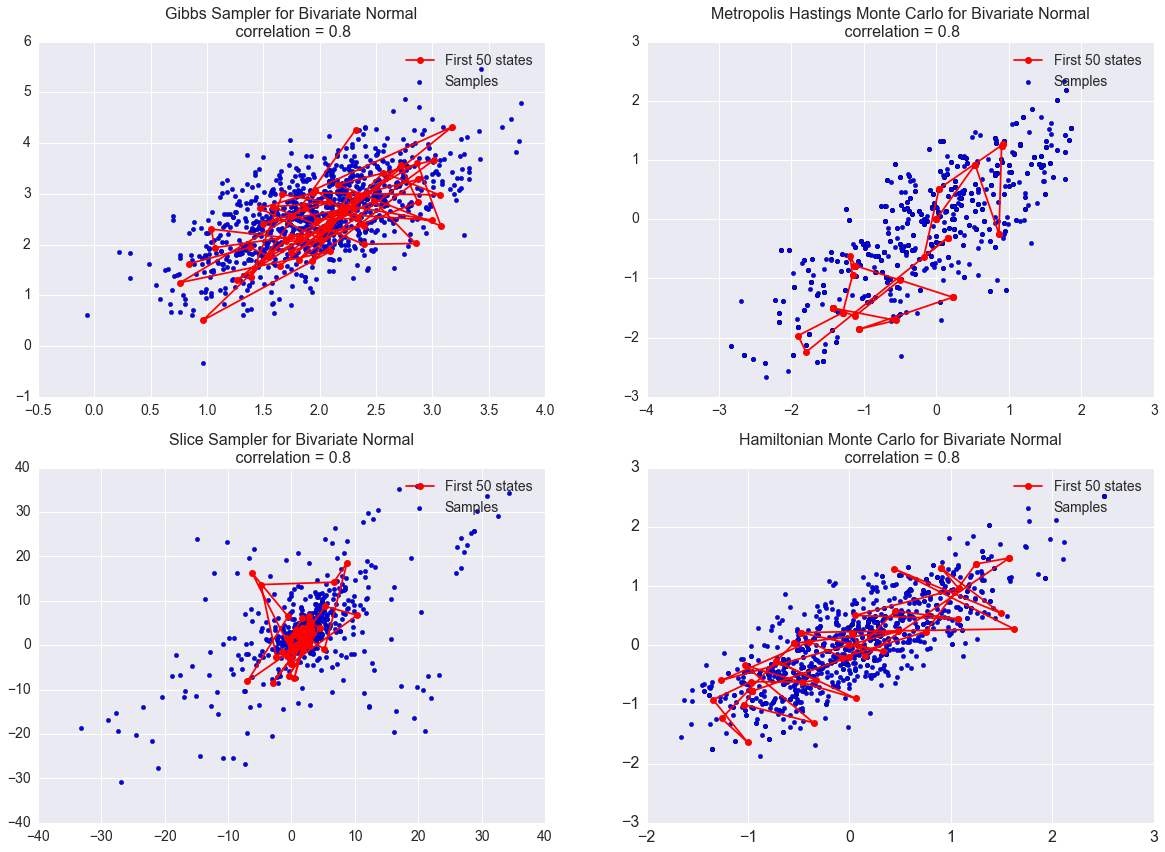

In [76]:
"""
CONVERGENCE PLOTS
"""

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,14))

axes[0][0].scatter(x_GIBBS[:,0],x_GIBBS[:,1])
axes[0][0].plot(x_GIBBS[:50,0],x_GIBBS[:50,1],'ro-')
axes[0][0].legend(['First 50 states','Samples'],fontsize=14)
axes[0][0].set_title("Gibbs Sampler for Bivariate Normal\n correlation = {}".format(corr),size=16)
axes[0][0].tick_params(axis='both', which='major', labelsize=14)

axes[0][1].scatter(x_MHMC[:,0],x_MHMC[:,1])
axes[0][1].plot(x_MHMC[:50,0],x_MHMC[:50,1],'ro-')
axes[0][1].legend(['First 50 states','Samples'],fontsize=14)
axes[0][1].set_title("Metropolis Hastings Monte Carlo for Bivariate Normal\n correlation = {}".format(corr),size=16)
axes[0][1].tick_params(axis='both', which='major', labelsize=14)

axes[1][0].scatter(x_SLICE[:,0],x_SLICE[:,1])
axes[1][0].plot(x_SLICE[:50,0],x_SLICE[:50,1],'ro-')
axes[1][0].legend(['First 50 states','Samples'],fontsize=14)
axes[1][0].set_title("Slice Sampler for Bivariate Normal\n correlation = {}".format(corr),size=16)
axes[1][0].tick_params(axis='both', which='major', labelsize=14)

axes[1][1].scatter(x_HMC[:,0],x_HMC[:,1])
axes[1][1].plot(x_HMC[:50,0],x_HMC[:50,1],'ro-')
axes[1][1].legend(['First 50 states','Samples'],fontsize=14)
axes[1][1].set_title("Hamiltonian Monte Carlo for Bivariate Normal\n correlation = {}".format(corr),size=16)
axes[1][1].tick_params(axis='both', which='major', labelsize=16)

pass

5. Empirical Analysis: Linear Regression
---

We compare different MCMC methods on a larger, real data set. The dataset contains 9568 observations collected in a Turkish Power Plant over 6 years. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant. 

For our model, we assume a simple Linear Regression framework, with 4 Predictors (T, AP, RH, V) and 1 Response (EP). We normalize the data in advance, as we are more interested in comparisons across methods than interpretation of coefficients.

$$\text{Model: }y = X\beta + \epsilon$$
$$\epsilon \sim N(0, \tau^{-1})$$
$$\beta \sim N(0, I)$$
$$\tau \sim \text{Gamma}(1, 1)$$

In [36]:
#Read in Power Plant Data and Normalize#
Data = pd.read_csv("MV_Data.csv")
std_scale = preprocessing.StandardScaler().fit(Data)
Data = std_scale.transform(Data)

#Set Predictor Matrix X and Response Vector Y#
X = Data[:,1:5]; Y = Data[:,5]

### Gibbs Sampling

In Bayesian Linear Regression, the conditional distribution of the parameters are:

$$p(\beta | y, X, \tau) \sim N_4(\hat{\mu}, \hat{\Sigma})$$
$$\hat{\Sigma} = (I + \tau X^TX)^{-1}$$
$$\hat{\mu} = (I + \tau X^TX)^{-1} (\tau X^Ty)$$

$$p(\tau | y, X, \beta) \sim \text{Gamma}(1 + \frac{n}{2}, 1 + \frac{1}{2} \displaystyle\sum_{i=1}^{n} (y_i - \beta^T x_i)^2)$$

In [37]:
def Gibbs_LinReg(X, y, niters):
    """
    Gibbs Sampler Algorithm for Bayesian Linear Regression Model
    
    Parameters
    ----------
    X : Matrix of shape n x p containing Predictors
    y : Vector of length n containing Response
    niters : Number of Iterations to Run
        
    Returns
    -------
    Beta : Matrix of Beta Samples after Burn-In
    Tau : Vector of Tau Samples after Burn-In
    """ 
    ##Set Priors##
    
    #Prior for Beta#
    b0 = np.zeros(4); E0 = np.eye(4)
    
    #Prior for Tau#
    a = 1; b = 1
    
    #Number of Observations
    n = X.shape[0]
    
    #Create Empty Matrix to store samples for Memory Allocation#
    Beta = np.zeros((niters+1)*4).reshape(niters+1,4)
    Tau = np.zeros(niters+1)

    #Run Sampler for 'niters' Iterations#
    for j in range(niters):
    
        #Calculate Mean and Variance of Beta Conditional Posterior#
        Mean = np.dot(la.inv(la.inv(E0) + np.dot(X.T, X)*Tau[j]),(np.dot(la.inv(E0), b0) + np.dot(X.T, y)*Tau[j]))
        Var = la.inv(la.inv(E0) + np.dot(X.T, X)*Tau[j])
        
        #Update Beta
        Beta[j+1,:] = np.random.multivariate_normal(Mean, Var)
        
        #Update Tau
        Tau[j+1] = np.random.gamma(a + n/2, (b + (1/2)*np.dot(y - np.dot(X,Beta[j+1,:]).T,(y - np.dot(X, Beta[j+1,:]))))**(-1))
    
    #Set Burn In#
    Burn_In = int(niters*0.1)
    
    return Beta[Burn_In:,:], Tau[Burn_In:]

### Metropolis-Hastings

We follow the same formulation as above in our Metropolis algorithm. In testing, we found that proposing each Beta value individually resulted in more acceptancces and thus more accurate estimations of our parameters. As the Metropolis algorithm involves a slow exploration of the posterior distribution, we Cythonize the Metropolis algorithm to speed it up

In [38]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [39]:
%%cython

#Import Necessary Python Modules#
import numpy as np
import cython
import scipy.stats as stats

cdef MH_Posterior(double Beta1, double Beta2, double Beta3, double Beta4, double Tau, double[:] Y, double[:,:] X):
    """
    Calculate Posterior Log-PDF For Specific Values of Beta and Tau
    
    Parameters
    ----------
    Beta1 : Coefficient for Temperature (T)
    Beta2 : Coefficient for Ambient Pressure (AP)
    Beta3 : Coefficient for Relative Humidity (RH)
    Beta4 : Coefficient for Exhaust Vaccuum (EV)
    Tau : Coefficient for Precision
    X : Matrix of shape n x p containing Predictors
    y : Vector of length n containing Response
        
    Returns
    -------
    Value of Posterior Log-PDF at specific Beta and Tau values
    """
    
    #Initialize n and Beta Vector#
    cdef int n = X.shape[0]
    Beta = np.array([Beta1, Beta2, Beta3, Beta4])
    
    #Calculate Log-Likelihood#
    Log_Lik = (n/2)*np.log(Tau) - (Tau/2) * np.dot(Y - np.dot(X,Beta).T,(Y - np.dot(X, Beta)))
    
    #Initialize Beta and Tau RV Objects#
    Beta_Prior = stats.multivariate_normal(mean = np.array([0,0,0,0]), cov = np.eye(4))
    Tau_Prior = stats.gamma(a = 1)
    
    #Return Log Posterior PDF#
    return(Log_Lik + Beta_Prior.logpdf(Beta) + Tau_Prior.logpdf(Tau))

@cython.boundscheck(False)
def MH_LinReg(double[:,:] X, double[:] Y, int niters):
    """
    Metropolis-Hastings algorithm for Bayesian Linear Regression
    
    Parameters
    ----------
    X : Matrix of shape n x p containing Predictors
    y : Vector of length n containing Response
    niters : Number of Iterations to Run
        
    Returns
    -------
    Beta : Matrix of Beta Samples after Burn-In
    Tau : Vector of Tau Samples after Burn-In
    """
    
    #Initialize Beta and Tau Vectors Individually
    Beta1 = np.array([0]); Beta2 = np.array([0]); Beta3 = np.array([0]); Beta4 = np.array([0])
    Tau = np.array([1])
    
    #Set Beta and Tau Tuning Parameters
    cdef double Beta_Tuning = 0.5
    cdef int Tau_Tuning = 1
    
    #Run sampler for 'niters' iterations#
    for T in range(niters):
        
        ##Propose Values, Calculate Log-Rho Value, and Accept/Reject##
        
        # Beta1 #
        Beta1_Star = np.random.normal(loc = Beta1[-1], scale = 0.1)
        rho = MH_Posterior(Beta1_Star, Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1], Y, X) - MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1], Y, X)
        U = np.random.uniform()
        if np.log(U) < rho:
            Beta1 = np.append(Beta1, Beta1_Star)
            
        # Beta2 #
        Beta2_Star = np.random.normal(loc = Beta2[-1], scale = 0.05)
        rho = MH_Posterior(Beta1[-1], Beta2_Star, Beta3[-1], Beta4[-1], Tau[-1], Y, X) - MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1], Y, X)
        U = np.random.uniform()
        if np.log(U) < rho:
            Beta2 = np.append(Beta2, Beta2_Star)
            
        # Beta3 #
        Beta3_Star = np.random.normal(loc = Beta3[-1], scale = 0.01)
        rho = MH_Posterior(Beta1[-1], Beta2[-1], Beta3_Star, Beta4[-1], Tau[-1], Y, X) - MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1], Y, X)
        U = np.random.uniform()
        if np.log(U) < rho:
            Beta3 = np.append(Beta3, Beta3_Star)
            
        # Beta4 #
        Beta4_Star = np.random.normal(loc = Beta4[-1], scale = 0.03)
        rho = MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4_Star, Tau[-1], Y, X) - MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1], Y, X)
        U = np.random.uniform()
        if np.log(U) < rho:
            Beta4 = np.append(Beta4, Beta4_Star)
        
        # Tau #
        Tau_Star = np.random.normal(loc = Tau[-1], scale = Tau_Tuning)
        rho = MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau_Star, Y, X) - MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1], Y, X)
        U = np.random.uniform()
        if np.log(U) < rho:
            Tau = np.append(Tau, Tau_Star)
    
        
    return np.array([Beta1, Beta2, Beta3, Beta4]), Tau

### Hamiltonian Monte Carlo

For our Hybrid Monte Carlo Algorithm, we need 2 pieces of information from our Linear Regression Model. For ease of computation, we will use the Logarithm of both results below, and set $\theta = \text{log}(\tau)$

1. Posterior Distribution
    * The 'Potential Energy' Function that we evaluate within our acceptance criterion
    * $p(\beta, \theta|X, y) = (\frac{n}{2} + 1)\theta - e^{\theta}(\frac{1}{2}(y - X\beta)^T(y - X\beta) + 1) - \frac{1}{2}\beta^T \beta$
2. Gradient of Posterior Distribution
    * Simulating Hamiltonian Dynamics, to simulate the subsequent Momentum and Parameter Variables
    * $\nabla L(\beta, \theta|X, y) = \begin{bmatrix}
  e^{\theta}X^T(y - X\beta) - \beta \\
  \frac{n}{2} + 1 - e^{\theta}(\frac{1}{2}(y - X\beta)^T(y - X\beta) + 1)
 \end{bmatrix}$

    








In [40]:
def unif(delta, low=.85, high=1.15):
    """
    Function to adaptively vary step size
    
    Parameters
    ----------
    delta : Current Step Size
    low : Lower bound of Uniform Random Sample
    high : Upper Bound of Uniform Random Sample
    
    Returns
    -------
    Updated Step Size between 0.85 and 1.15 times current Step Size
    
    """
    return np.random.uniform(low, high) * delta
    
def log_grad(X, Y, Beta, Tau):
    """
    Evaluates the Log-Gradient of the Posterior Distribution for Beta and Tau
    
    Parameters
    ----------
    X : Matrix of shape n x p containing Predictors
    Y : Vector of length n containing Response
    Beta : Vector of Current Beta Values
    Tau : Vector of Current Tau Value
    
    Returns
    -------
    Gradient vector of length p+1
    
    """
    ##Set Priors##
    
    #Prior for Beta#
    b0 = np.zeros(4); E0 = np.eye(4)
    
    #Prior for Tau#
    a = 1; b = 1
    
    #Calculate number of observations#
    n = X.shape[0]
    
    dBeta = np.exp(Tau) * np.dot(X.T,(Y - np.dot(X,Beta))) - np.dot(la.inv(E0),(Beta - b0))
    dTau = n/2 + a - np.exp(Tau)*((1/2)*np.dot((Y - np.dot(X,Beta)).T,(Y - np.dot(X,Beta))) + b)
    return np.append(dBeta, dTau)
    
def potential_energy(X, Y, Beta, Tau):
    """
    Evaluates the Log of the Posterior Distribution for Beta and Tau
    
    Parameters
    ----------
    X : Matrix of shape n x p containing Predictors
    Y : Vector of length n containing Response
    Beta : Vector of Current Beta Values
    Tau : Vector of Current Tau Value
    
    Returns
    -------
    The Log of the Posterior Distribution under inputs
    
    """
    ##Set Priors##
    
    #Prior for Beta#
    b0 = np.zeros(4); E0 = np.eye(4)
    
    #Prior for Tau#
    a = 1; b = 1
    
    #Calculate number of observations#
    n = X.shape[0]
    
    return((n/2 + a)*Tau - np.exp(Tau)*((1/2)*np.dot(Y - np.dot(X,Beta).T,(Y - np.dot(X, Beta))) + b) - (1/2)*np.dot(Beta.T,np.dot(la.inv(E0),Beta)))
        
def kinetic_energy(p):
    """
    Evaluates the PDF for the Momentum Variables (Multivariate Normal). This is used in accept/reject step
    
    Parameters
    ----------
    p : Vector of Momentum Values to calculate the PDF for
    
    Returns
    -------
    Single value containing the PDF for a MVN as the p vetor values
    
    """
    mvn = stats.multivariate_normal()
    return (np.sum(mvn.logpdf(p)))

def HMC_LinReg(X, Y, niters):
    """
    Hamiltonian Monte Carlo algorithm for Bayesian Linear Regression
    
    Parameters
    ----------
    X : Matrix of shape n x p containing Predictors
    y : Vector of length n containing Response
    niters : Number of Iterations to Run
        
    Returns
    -------
    Beta : Matrix of Beta Samples after Burn-In
    Tau : Vector of Tau Samples after Burn-In
    """
    
    #Calculate number of observations#
    n = X.shape[0]
    
    #Set Step-Size (Delta) And Number of Leaps#
    delta = 0.25/np.sqrt(n)
    leap = int(2/delta)
    
    #Initialize Array to Hold Beta and Tau Accepted Proposals
    Vars = np.array([0,0,0,0,0]).reshape(1,5)
    
    #Run sampler for 'niters' iterations
    for t in range(niters):
        
        #Choose step size adaptively at each iteration#
        delta = unif(delta)
                    
        #Sample Random Momentum#
        p0 = np.random.randn(5)
            
        ##Simulate Hamiltonian Dynamics##
        
        #First 1/2 Step of Momentum
        p_star = p0 - (1/2)*delta*-log_grad(X, Y, Vars[-1,:4], Vars[-1,4])
        
        #Set Proposed Variable Values to previous accepted Value#
        Vars_Star = Vars[-1,:]
 
        #Full Steps of Momentum and Variable#
        for i in range(leap):
            
            #First full step of position/sample
            Vars_Star = Vars_Star + delta*p_star
            
            if i != leap-1:
            
                #Update Momentum on all but last leap step#
                p_star = p_star - delta*-log_grad(X, Y, Vars_Star[:4], Vars_Star[4])
        
        #Final 1/2 Step of Momentum#
        p_star = p_star - delta/2*-log_grad(X, Y, Vars_Star[:4], Vars_Star[4])
        
        #Negate p_star to conserve energy#
        p_star = -p_star
        
        #Potential Energy at Proposed and Previous Variables#
        U0 = potential_energy(X, Y, Vars[-1,:4], Vars[-1,4])
        U_star = potential_energy(X, Y, Vars_Star[:4], Vars_Star[4])
    
        #Kinetic Energy for Proposed and Previous Momentum#
        K0 = kinetic_energy(p0)
        K_star = kinetic_energy(p_star)
        
        #Log Acceptance Ratio#
        alpha = U_star + K_star - (U0 + K0)
        
        #Accept/Reject Condition
        if np.log(np.random.random()) < alpha:
            Vars = np.vstack([Vars, Vars_Star])

    return Vars[:,:4], np.exp(Vars[:,4])

In [41]:
Beta_G, Tau_G = Gibbs_LinReg(X, Y, 10000)
Beta_M, Tau_M = MH_LinReg(X, Y, 10000)
Beta_HMC, Tau_HMC = HMC_LinReg(X, Y, 10000)

### Comparisons

$$\text{Parameter Estimates}$$

||$\mathbf{\beta_1}$|$\mathbf{\beta_2}$|$\mathbf{\beta_3}$|$\mathbf{\beta_4}$|$\mathbf{\tau}$|
|--|:---:|:---:|:---:|:---:|:---:|
|OLS | -0.8635 | -0.1742 | 0.0216 | -0.1352 | ---
|Gibbs |-0.8635 | -0.1742 | 0.0216 | -0.1352 | 13.9793
|Metropolis | -0.8529 | -0.1731 | 0.0217 | -0.1347 | 13.9224
|HMC | -0.8529 | -0.1731 | 0.0217 | -0.1347 | 13.9224

We can see that all MCMC Methods and OLS provide very accurate estimates for the $\beta$ and $\tau$ coefficients. Across all the methods, it is interesting to look at the variance of the estimates as well as the number of iterations until convergence.

$$\text{Variances}$$

||$\mathbf{\beta_1}$|$\mathbf{\beta_2}$|$\mathbf{\beta_3}$|$\mathbf{\beta_4}$|$\mathbf{\tau}$|
|--|:---:|:---:|:---:|:---:|:---:|
|Gibbs |4.5231e-05| 2.9383e-05| 1.0999e-05| 1.26843e-05 | 0.04119
|Metropolis | 0.00639 | 0.00016| 1.6464e-05 | 0.0001 | 0.5916
|HMC | 2.0170e-04|   7.0564e-05|   6.3290e-06| 1.4140e-05 | 0.05403

We define convergence here as the Iteration at which the difference between the accepted parameter sample and the previous sample is less than $10^{-5}$

$$\text{Number of Iterations until Convergence}$$

||$\mathbf{\beta_1}$|$\mathbf{\beta_2}$|$\mathbf{\beta_3}$|$\mathbf{\beta_4}$|$\mathbf{\tau}$|
|--|:---:|:---:|:---:|:---:|:---:|
|Gibbs |1330| 1396| 1988| 1800 | 1329
|Metropolis | 235 | 57| 252 | 16 | 1050
|HMC | 695|   82|   504| 35 | 20

We can see that Gibbs Sampling converges well with low variances of the parameter estimates, but it takes quite a number of iterations to converge. This result is likely due to the 'Burn In' period needed for the Gibbs algorithm. 

Our Metropolis Sampler converged quite quickly, but it is important to note that this convergence is evaluated on the *accepted* proposals, of which for the total number of $\beta$ coefficients there were roughly 500, and for the $\tau$ precision, about 2500. The main flaw of the Metropolis algorithm is its 'random walk' behavior, and we can see that with the exceptionally high variances of our accepted parameter estimates.

The Hamiltonian Monte Carlo algorithm balanced both a low variance in the parameter estimates and a low number of iterations until convergence. In a separate test of just 100 Iterations, the HMC algorithm is able to quickly find the appropriate parameter estimates.

6. Conclusion
----

7. References
---